# CogPonder: An Interoperable Model of Response Times in Cognitive Tasks

The dataset interface provides the following features:

- $X_i$: previous 3 symbols for the trial i; $X_i$ is a 3-dimensional vector of integers.
- $\text{trial\_type}_i$: see the "Trial types" section below.
- $\text{is\_target}_i$: whether the trial i is a match; $is\_targets_i$ is a boolean.
- $\text{response}_i$: the response of the subject for the trial i; $responses_i$ is a boolean.
- $\text{response\_step}_i$: the response step of the subject for the trial i; $response\_times_i$ is a float. Response steps represent RT in 50ms steps.

### Criterion

$L = L_{\text{reconstruction}} + L_{\text{cognitive}}$


In [1]:
%reload_ext autoreload
%autoreload 3

import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from ray import tune, air
from ray.tune import JupyterNotebookReporter
from functools import partial
from pytorch_lightning.callbacks import RichProgressBar, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from cogponder import CogPonderNet, ICOM
from cogponder.datasets import NBackMockDataset, NBackDataModule, NBackSRODataset
from pathlib import Path

In [2]:

# load the data
# mock_data = NBackMockDataset(n_subjects=1, n_trials=198, n_stimuli=5, n_back=2)

# create data module for handling data in PyTorch Lightning

data = NBackSRODataset(n_subjects=1, n_back=2) # shape (n_subjects, (...))
datamodule = NBackDataModule(data, batch_size=8)
n_symbols = torch.unique(data[0][0]).shape[0]
max_response_step = data[0][4].max() + 10
lambda_p = 1. / data[0][4].median()

max_response_step = max_response_step.item()
lambda_p = lambda_p.item()

# parameter space
CONFIG = {
    'loss_beta': .5,
    'loss_by_trial_type': False,
    'learning_rate': 1e-4,
    'max_response_step': max_response_step,
    'lambda_p': lambda_p,
    'n_symbols': n_symbols,
    'embeddings_dim': n_symbols,
}

In [3]:
decision_model = ICOM(n_inputs=n_symbols+1, n_embeddings=n_symbols, n_outputs=2)

# pondering model
model = CogPonderNet(
    decision_model,
    CONFIG,
    example_input_array=data[0][0][:2])

trainer = pl.Trainer(
    max_epochs=-1,
    log_every_n_steps=8,
    auto_scale_batch_size=True,
    callbacks=[
        RichProgressBar(),
        EarlyStopping(monitor='val_loss', patience=10, mode='min', min_delta=0.01),
    ])

trainer.fit(model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name           ┃ Type       ┃ Params ┃            In sizes ┃           Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ decision_model │ ICOM       │    100 │ [[2, 3], [1, 2, 5]] │ [[2, 2], [1, 2, 5]] │
│ 1 │ halt_node      │ Sequential │      7 │           [1, 2, 6] │           [1, 2, 1] │
└───┴────────────────┴────────────┴────────┴─────────────────────┴─────────────────────┘

Trainable params: 107                                                                                              
Non-trainable params: 0                                                                                            
Total params: 107                                                                                                  
Total estimated model params size (MB): 0

Output()

# WARNING: the remaining codes won't work with Ray-Tune.

Please use previous version of the notebook from the git.

In [4]:
# DEBUG

import torch

X_train, _, _, _, rt_train = datamodule.dataset[datamodule.train_dataset.indices]
X_test, _, _, _, rt_test = datamodule.dataset[datamodule.test_dataset.indices]

with torch.no_grad():
    model.eval()
    rt_train_pred = model(X_train)[2].detach()
    rt_test_pred = model(X_test)[2].detach()

    # DEBUG report the ground truth and predicted response times
    print('TRUE TRAIN:', rt_train.detach().tolist(), '\nPRED TRAIN:',  rt_train_pred.tolist())
    print('TRUE TEST:', rt_test.detach().tolist(), '\nPRED TEST:',  rt_test_pred.tolist())

# DEBUG report medians
# rt_train_pred.median(), rt_train.float().median()
# rt_test_pred.median(), rt_test.float().median()


TRUE TRAIN: [9, 8, 10, 14, 13, 10, 8, 9, 11, 10, 11, 8, 10, 8, 9, 9, 5, 5, 7, 7, 6, 6, 6, 6, 7, 12, 15, 14, 10, 11, 9, 8, 12, 12, 12, 10, 7, 9, 13, 14, 12, 8, 5, 5, 6, 10, 11, 10, 10, 8, 8, 14, 9, 10, 7, 7, 6, 5, 6, 6, 10, 8, 10, 8, 10, 6, 7, 7, 10, 10, 8, 8, 7, 6, 7, 11, 10, 15, 9, 5, 5, 5, 5, 7, 8, 14, 10, 6, 7, 5, 9, 9, 12, 10, 11, 14, 6, 8, 10, 9, 15, 6, 6, 8, 14, 12, 13, 9, 8, 8, 7, 14, 13, 8, 7, 10, 12, 8, 8, 9, 10, 5, 7, 8, 7, 6, 11, 6, 10, 9, 8, 5, 9, 7, 8, 10, 8, 11, 8, 8, 7, 8, 6, 10, 7, 5, 8, 9, 8, 7, 10, 9, 7, 4, 8, 9] 
PRED TRAIN: [5, 1, 3, 3, 1, 1, 1, 4, 1, 1, 5, 2, 1, 2, 1, 3, 1, 1, 3, 1, 2, 3, 1, 2, 8, 1, 3, 2, 2, 2, 3, 2, 1, 1, 1, 1, 1, 2, 1, 6, 1, 3, 1, 3, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 2, 1, 3, 1, 1, 1, 2, 4, 1, 1, 3, 5, 2, 1, 1, 2, 1, 1, 2, 2, 3, 1, 3, 3, 5, 1, 1, 2, 3, 2, 4, 1, 3, 5, 4, 2, 1, 1, 3, 2, 1, 3, 1, 3, 2, 4, 2, 1, 5, 3, 1, 1, 1, 5, 1, 1, 2, 11, 1, 2, 2, 1, 2, 1, 3, 3, 3, 1, 1, 3, 1, 1, 5, 2, 2, 1, 2, 1, 1, 1, 1, 1, 3, 3, 1, 5, 1, 1, 4, 2, 2, 2, 1, 1, 1, 1

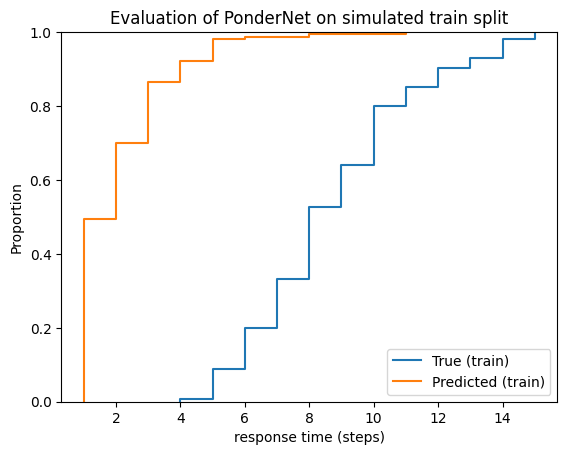

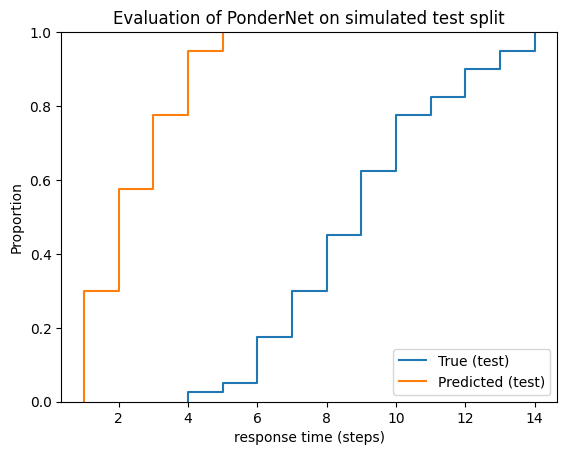

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.ecdfplot(rt_train.detach(), label='True (train)')
sns.ecdfplot(rt_train_pred.detach(), label='Predicted (train)')

plt.title('Evaluation of PonderNet on simulated train split')
plt.xlabel('response time (steps)')

plt.legend()
plt.show()

sns.ecdfplot(rt_test.detach(), label='True (test)')
sns.ecdfplot(rt_test_pred.detach(), label='Predicted (test)')

plt.title('Evaluation of PonderNet on simulated test split')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()

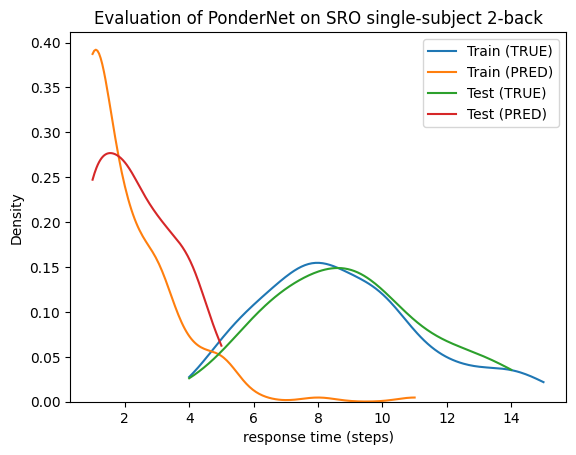

In [6]:

sns.kdeplot(rt_train.detach(), label='Train (TRUE)', cut=0)
sns.kdeplot(rt_train_pred.detach(), label='Train (PRED)', cut=0)

sns.kdeplot(rt_test.detach(), label='Test (TRUE)', cut=0)
sns.kdeplot(rt_test_pred.detach(), label='Test (PRED)', cut=0)


plt.title('Evaluation of PonderNet on SRO single-subject 2-back')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()